# Handwritten Digit Recognition

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.display import clear_output, display
from PIL import Image
from ipywidgets import Button, FileUpload, Output
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pygame


pygame 2.6.0 (SDL 2.28.4, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Load and preprocess the MNIST dataset
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

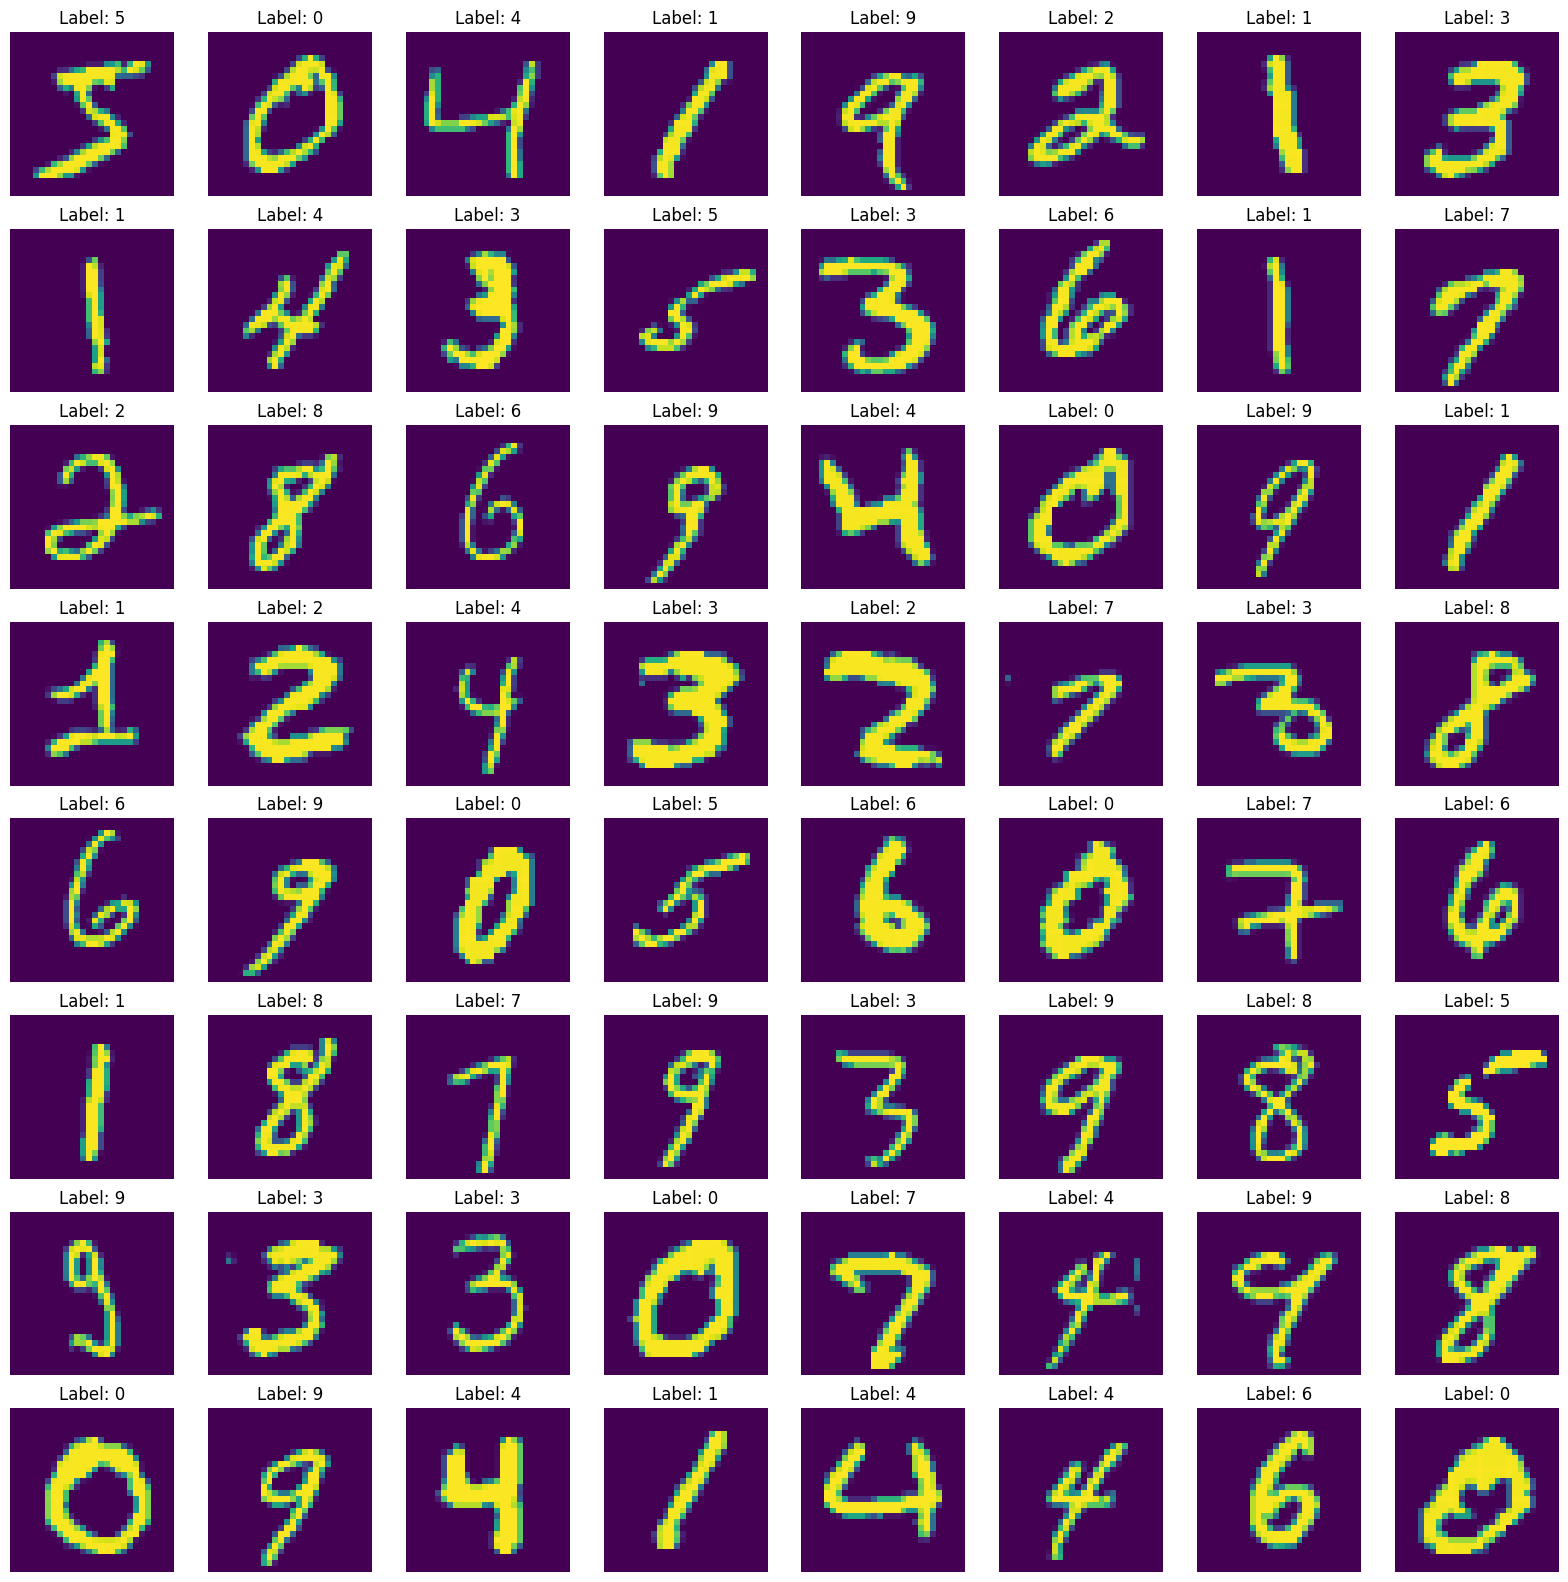

In [3]:
# plot
fig, axes = plt.subplots(8,8, figsize=(20,20))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.show()

In [6]:
# reshape the data for CNN

shape_train = X_train.shape[0]
shape_test = X_test.shape[0]
X_train_cnn = X_train.reshape(shape_train, 28, 28, 1)
X_test_cnn = X_test.reshape(shape_test, 28, 28, 1)

y_train_cnn = keras.utils.to_categorical(y_train, 10)
y_test_cnn = keras.utils.to_categorical(y_test, 10)
print(X_train_cnn.shape, X_test_cnn.shape, y_train_cnn.shape, y_test_cnn.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)


In [27]:
# Define the model
def model_digit_recognition():
    model = models.Sequential()

    # First convolutional block (Conv1 + Conv2 + Pooling)
    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))  # (28x28)
    model.add(layers.MaxPooling2D((2, 2)))  # Downsample to (14x14)

    # Second convolutional block (Conv3 + Conv4 + Pooling)
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))  # (14x14)
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))  # (14x14)
    model.add(layers.MaxPooling2D((2, 2)))  # Downsample to (7x7)

    # Flatten and fully connected layers (FC1, FC2, FC3)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))  # 10 outputs for 10 classes (digits 0-9)

    return model

# Create the model
model = model_digit_recognition()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # for digit classification
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3 , mode='min', verbose=1, restore_best_weights=True)
# Model checkpoint
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, verbose=1, monitor='val_loss', mode='min')

model.summary()

# Fit the model using the augmented data generator
history = model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=64, validation_split = 0.2, callbacks=[model_checkpoint, early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                  

In [28]:
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(X_test_cnn, y_test_cnn, verbose=1)
print(f"Test accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, Loss: {test_loss:.4f}")

313/313 [==============================] - 2s 7ms/step - loss: 0.0260 - accuracy: 0.9934 - auc: 0.9993 - precision: 0.9938 - recall: 0.9929
Test accuracy: 0.9934, AUC: 0.9993, Precision: 0.9938, Recall: 0.9929, Loss: 0.0260


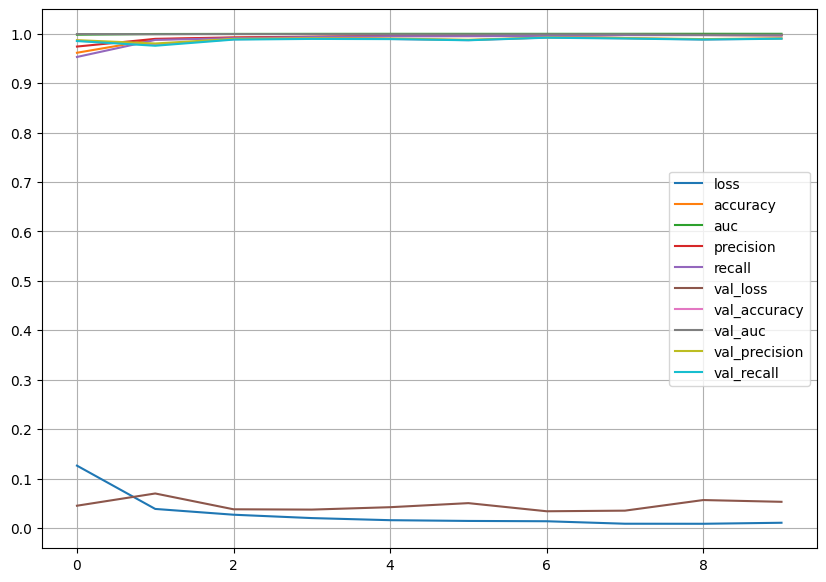

In [41]:
graph = pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [7]:
# Load the best model
model = load_model('best_model.keras')

# Test the model
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(X_test_cnn, y_test_cnn, verbose=1)

print(f"Test accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, Loss: {test_loss:.4f}")

313/313 [==============================] - 5s 6ms/step - loss: 0.0260 - accuracy: 0.9934 - auc: 0.9993 - precision: 0.9938 - recall: 0.9929
Test accuracy: 0.9934, AUC: 0.9993, Precision: 0.9938, Recall: 0.9929, Loss: 0.0260


313/313 [==============================] - 1s 4ms/step


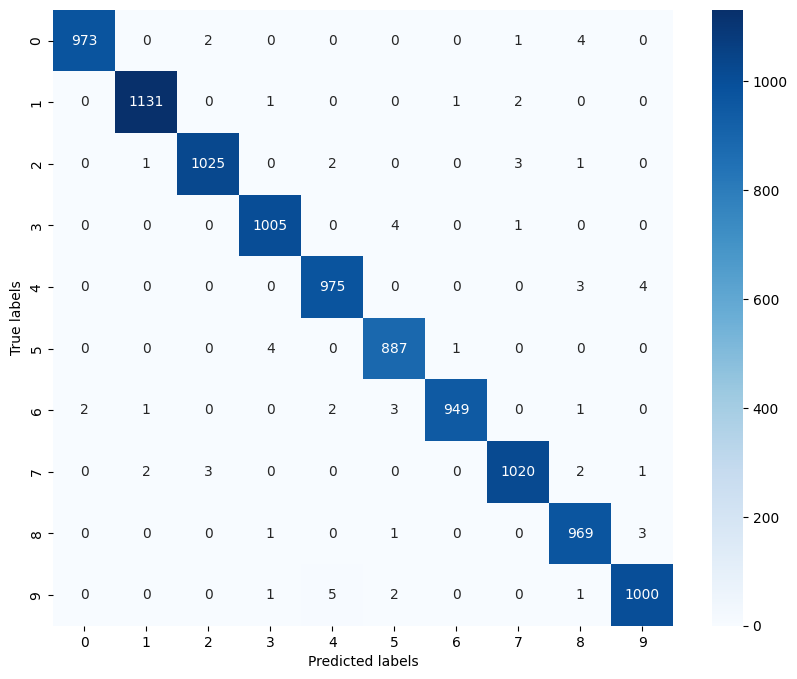

In [9]:
# confusion matrix
y_pred = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_cnn, axis=1)
confusion = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(confusion):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

plot_confusion_matrix(confusion)

In [32]:
# Save the model
model.save('mnist_model_cnn.h5')

In [43]:
def cnn_lstm():
    model = models.Sequential()
    
    # Backbone: Convolutional layers with downsampling
    model.add(layers.Input(shape = (28, 28, 1)))
    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # SPP Layer (Spatial Pyramid Pooling)
    model.add(layers.GlobalMaxPooling2D())

    # LSTM layer
    model.add(layers.RepeatVector(1))  # Reshaping for LSTM compatibility
    model.add(layers.LSTM(128, return_sequences=False)) # LSTM layer with 128 units and return only the last output

    # Fully connected layers as the detection head
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer for 10 classes (digits 0-9)
    model.add(layers.Dense(10, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Instantiate the CNN-LSTM model
cnn_lstm_model = cnn_lstm()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3 , mode='min', verbose=1, restore_best_weights=True)
# Model checkpoint
model_checkpoint = ModelCheckpoint('best_model_cnn-lstm.keras', save_best_only=True, verbose=1, monitor='val_loss', mode='min')

# Model summary
cnn_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                      

In [44]:
# Split the data into training and validation sets
X_train_cnn_train, X_train_cnn_val, y_train_cnn_train, y_train_cnn_val = train_test_split(X_train_cnn, y_train_cnn, test_size=0.1, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=10, 
    zoom_range=0.1, 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=False,
    shear_range=0.1
)

# Fit the model using the training data and validate using the validation data
hist = cnn_lstm_model.fit(datagen.flow(X_train_cnn_train, y_train_cnn_train, batch_size=32),
                                    epochs=10,
                                    validation_data=(X_train_cnn_val, y_train_cnn_val),
                                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
1686/1688 [============================>.] - ETA: 0s - loss: 0.3606 - accuracy: 0.8894 - auc_1: 0.9905 - precision_1: 0.9527 - recall_1: 0.8528
Epoch 1: val_loss improved from inf to 0.06608, saving model to best_model_cnn-lstm.keras
1688/1688 [==============================] - 35s 19ms/step - loss: 0.3604 - accuracy: 0.8894 - auc_1: 0.9905 - precision_1: 0.9527 - recall_1: 0.8529 - val_loss: 0.0661 - val_accuracy: 0.9808 - val_auc_1: 0.9988 - val_precision_1: 0.9852 - val_recall_1: 0.9778
Epoch 2/10
1686/1688 [============================>.] - ETA: 0s - loss: 0.1267 - accuracy: 0.9686 - auc_1: 0.9967 - precision_1: 0.9743 - recall_1: 0.9640
Epoch 2: val_loss improved from 0.06608 to 0.06352, saving model to best_model_cnn-lstm.keras
1688/1688 [==============================] - 32s 19ms/step - loss: 0.1268 - accuracy: 0.9686 - auc_1: 0.9967 - precision_1: 0.9743 - recall_1: 0.9640 - val_loss: 0.0635 - val_accuracy: 0.9838 - val_auc_1: 0.9983 - val_precision_1: 0.9853 - val_r

In [63]:
model = load_model('best_model_cnn-lstm.keras')

# Test the model
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(X_test_cnn, y_test_cnn, verbose=1)

print(f"Test accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, Loss: {test_loss:.4f}")


313/313 [==============================] - 3s 7ms/step - loss: 0.0466 - accuracy: 0.9856 - auc_1: 0.9993 - precision_1: 0.9873 - recall_1: 0.9834
Test accuracy: 0.9856, AUC: 0.9993, Precision: 0.9873, Recall: 0.9834, Loss: 0.0466


313/313 [==============================] - 1s 4ms/step
[[ 966    1    5    0    0    2    6    0    0    0]
 [   0 1131    1    0    0    0    0    3    0    0]
 [   0    2 1025    0    0    1    0    4    0    0]
 [   0    0    1  998    0    7    0    4    0    0]
 [   0    1    1    0  965    0    0    1    0   14]
 [   0    1    0    5    0  885    1    0    0    0]
 [   5    8    0    0    3    5  936    0    0    1]
 [   0    3    2    0    0    0    0 1023    0    0]
 [   3    0    1   11    0   10    3    1  933   12]
 [   1    0    3    0    2    8    0    1    0  994]]


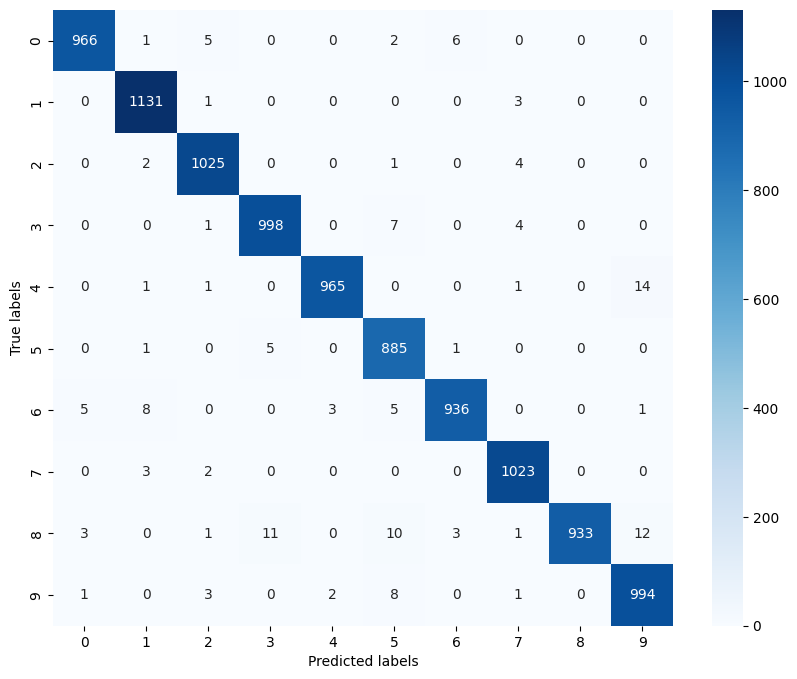

In [66]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_cnn, axis=1)
confusion_matrix_result = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(confusion_matrix_result)


In [10]:
import io
import os
from ipywidgets import FileUpload, Button, Output
from IPython.display import display, clear_output

In [11]:
model = load_model('best_model_cnn-lstm.keras')

In [12]:
# Function to preprocess the input image
def preprocess_image(image):
    img = image.convert('L')  # Convert to grayscale
    img = img.resize((28, 28))  # Resize to match the model's input size (28x28)

    # Convert image to a numpy array
    img_array = np.array(img) 
    
    # Invert colors if background is white and digit is black
    if np.mean(img_array) > 127:  # Assuming white background if average pixel value > 127
        print('Inverting colors')
        img_array = 255 - img_array
    else:
        print('Colors are okay')
        
    # Normalize pixel values
    img_array = img_array.astype('float32') / 255.0

    # Reshape the image to add batch dimension (1, 28, 28, 1)
    img_array = img_array.reshape(28, 28, 1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [13]:
# Function to predict the digit from user input
def predict_digit(image,*args, **kwargs):
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)  # Assuming model is already loaded
    predicted_digit = np.argmax(prediction)
    return predicted_digit

In [14]:
# Create widgets
upload = FileUpload(accept='image/*', multiple=False)
predict_button = Button(description="Predict", disabled=True)
image_output = Output()
prediction_output = Output()

# Variable to hold the uploaded image
uploaded_image = None

# Function to handle file upload
def handle_upload(change): 
    global uploaded_image
    
    # Check if the file is uploaded correctly
    if upload.value:
        # Extract the uploaded file's content from the widget
        uploaded_file = upload.value[::-1][0]  # Reverse the order of the uploaded files and get the first file (latest) because the file is uploaded as a list
        image_data = uploaded_file['content']  # Get the content of the uploaded file as bytes
        
        # Convert the file content to a PIL Image
        uploaded_image = Image.open(io.BytesIO(image_data))
        
        # Display the uploaded image
        with image_output:
            clear_output(wait=True)
            plt.imshow(uploaded_image, cmap='gray')
            plt.title("Uploaded Image")
            plt.axis('off')  # Hide axis
            plt.show()

        # Enable the predict button after upload
        predict_button.disabled = False

# Function to handle prediction when the button is clicked
def on_predict_button_clicked(b):
    if uploaded_image is not None:
        predicted_digit = predict_digit(uploaded_image)
        
        # Display the prediction result
        with prediction_output:
            clear_output(wait=True)
            print(f"Predicted Digit: {predicted_digit}")

# Attach handlers to the widgets
upload.observe(handle_upload, names='value') 
predict_button.on_click(on_predict_button_clicked)

# Display the widgets
display(upload)
display(predict_button)
display(image_output)  # Display the image output widget
display(prediction_output)  # Display the prediction output widget

FileUpload(value=(), accept='image/*', description='Upload')

Button(description='Predict', disabled=True, style=ButtonStyle())

Output()

Output()

Colors are okay
1/1 [==============================] - 2s 2s/step


TypeError: predict_digit() takes 0 positional arguments but 1 was given

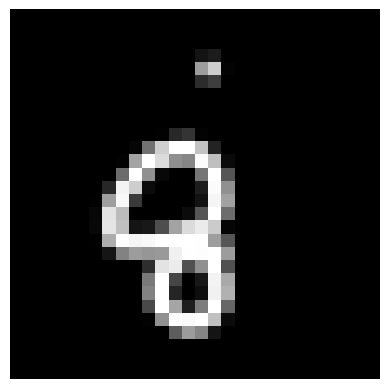

1/1 [==============================] - 0s 21ms/step
Predicted Digit: 8


In [16]:
digit = Image.open('digit7.png')
digit = digit.convert('L')
digit = digit.resize((28, 28))
digit = np.array(digit)

if np.mean(digit) > 127:  # Assuming white background if average pixel value > 127
        print('Inverting colors')
        digit = 255 - digit

digit = digit.astype("float32")/255.0
plt.imshow(digit, cmap='gray')
plt.axis('off')
plt.show()

digit = digit.reshape(1, 28, 28, 1)

prediction = model.predict(digit)
predicted_digit = np.argmax(prediction)
print(f"Predicted Digit: {predicted_digit}")


In [15]:
# function to draw the digit on the screen
def draw_digit():
    # initialize the pygame
    pygame.init()
    
    # set the screen size
    screen = pygame.display.set_mode((280, 280)) 
    
    # set the title of the screen
    pygame.display.set_caption('Draw Digit')
    
    # set the color
    color = (255, 255, 255)
    
    # set the thickness
    thickness = 8
    
    # set the running variable
    running = True
    
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False                    
            if event.type == pygame.MOUSEBUTTONDOWN:
                pygame.draw.circle(screen, color, event.pos, thickness)
            if event.type == pygame.MOUSEMOTION and event.buttons[0]: 
                pygame.draw.circle(screen, color, event.pos, thickness)
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RETURN:
                    # get the screen as an image
                    pygame.image.save(screen, 'digit7.png')
                    
                    
                    pygame.display.flip()
                        
                    # quit the pygame
                    pygame.quit()
    
# function to take the input from the user to predict the digit in three different ways
def predict_digit():
    # take the input from the user
    print('Select the input method:')
    print('1. Draw digit')
    choice = input('Enter your choice: ')
    
    # predict the digit based on the user's choice
    if choice == '1':
        draw_digit()
    else:
        print('Invalid choice')
        
# predict the digit
predict_digit()

Select the input method:
1. Draw digit
